# Деревья решений
Шестаков А.В., Панов А.И. Майнор по анализу данных 12/04/2016

На прошлых занятиях мы рассматривали **линейные** модели классификации и регрессии. Деревья решений - совсем другая история. Во-первых, потому что их можно использовать и для регрессии и для классификации, а во-вторых линейностью там только слегка веет.

Формально, деревья решений можно представить в виде вложенного набора правил "Если - То", но гораздо нагляднее изображать их именно в виде дерева.

Например, дерево может выглядеть так:

<img src='https://raw.githubusercontent.com/alexeygrigorev/wiki-figures/master/ufrt/kddm/decision-tree-ex-tit.png'>

Или вот так:

<img src='http://scikit-learn.org/stable/_images/iris.svg'>

### Классификация с деревьями решений

Давайте попробуем вспомнить, как они стоятся. Рассмотрим следующий набор данных


| ID | Refund | Marital Status | Income | Cheat
|-
| 1 | Yes | Single | 125K | No
| 2 | No | Married | 100K | No
| 3 | No | Single | 70K | No
| 4 | Yes | Married | 120K | No
| 5 | No | Divorced | 95K | Yes
| 6 | No | Married | 60K | No
| 7 | Yes | Divorced | 220K | No
| 8 | No | Single | 85K | Yes
| 9 | No | Married | 75K | No
| 10 | No | Single | 90K | Yes


Имеем 3 признака и класс *Cheat*. Нужно выбрать признак, который наилучшим образом дифференцирует между классами. Посчитать это можно с помощью Impurity Measures и прироста информации:

**Impurity Measures: (меры неравенства\неопределенности)**
* Gini index $I(S) = 1 - \sum\limits_k (p_k)^2$
* Entropy  $I(S) = -\sum\limits_k p_k \log(p_k)$
* Missclassification error  $I(S) = 1 - \max\limits_k p_k$

$p_k$ - доля класса $k$ в узле дерева $S$

**Прирост информации: (насколько уменьшится неопределенность)** <br/>
$$ Gain(S, A) = I(S) - \sum\limits_v\frac{|S_v|}{|S|}\cdot I(S_v),$$ где $A$ - это некий атрибут, а $v$ - его значения

Например, для нашей таблицы:
$$I(S) = -(\frac{3}{10}\log(\frac{3}{10}) + \frac{7}{10}\log(\frac{7}{10})) = 0.61$$

Возьмем, например, атрибут *Marital Status*

$$Gain(S, \text{'Marital Status'}) = I(S) - (\frac{4}{10}\cdot I(S_{single}) + \frac{2}{10}\cdot I(S_{divorced}) + \frac{4}{10}\cdot I(S_{married})) =  0.14$$

Проделаем тоже самое для остальных атрибутов..

In [1]:
import math

I_S = 0.88
I_single = -(0.5*math.log2(0.5)+0.5*math.log2(0.5))
I_divorced = -(0.5*math.log2(0.5)+0.5*math.log2(0.5))
I_married = -(1*math.log(1))
Gain = 0.88-(0.4*I_single+0.2*I_divorced+0.4*I_married)
Gain

I_RY = -(1*math.log2(1))
I_RN = -((3/7)*math.log2(3/7)+(4/7)*math.log2(4/7))
Gain2 = 0.88 - 0.3*I_RY - 0.7*I_RN
print(Gain, Gain2, 2., sep = '\n')

0.2799999999999999
0.19034030477602393
2.0


In [6]:
from sklearn import tree
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

In [3]:
clf.predict([[0., 1.]])

array([0])

In [4]:
clf.predict_proba([[0.51, 0.]])

array([[ 0.,  1.]])

In [5]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

{'DESCR': 'Iris Plants Database\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)\n    ============== ==== ==== ======= ===== ====================\n\n

### Как посмотреть на деревья?

In [62]:
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value
        
        def recourse(node, counter):
            if (threshold[node] != 2):
                if left[node] != -1:
                    print(' '*counter + 'if(' + features[node] +'>' + str(threshold[node]) + '){')
                    recourse(left[node], counter + 2)
                    print(' '*counter + '}else{')
                if right[node] != -1:
                    #print('if('+ features[node] +'>' + str(threshold[node])+'){')
                    recourse(right[node],counter + 2)
                    print(' '*counter + '}')
            else:
                print('return' + str(value[node]))
        recourse(0, 0)

        ### Your recursive funtion of print

In [63]:
get_code(clf, iris.feature_names)

if(petal width (cm)>0.800000011921){
}else{
  if(petal width (cm)>1.75){
    if(petal length (cm)>4.94999980927){
      if(petal width (cm)>1.65000009537){
      }else{
      }
    }else{
      if(petal width (cm)>1.54999995232){
      }else{
        if(sepal length (cm)>6.94999980927){
        }else{
        }
      }
    }
  }else{
    if(petal length (cm)>4.85000038147){
      if(sepal length (cm)>5.94999980927){
      }else{
      }
    }else{
    }
  }
}


In [14]:
from sklearn.externals.six import StringIO
with open("iris.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

Затем можно с помощью [Graphviz](http://www.graphviz.org/Download..php) создать pdf или другой поддерживаемый тип файла: `dot -Tpdf iris.dot -o iris.pdf`

In [15]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("iris.pdf")

ImportError: No module named 'pydot'

In [8]:
from IPython.display import Image  
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

NameError: name 'pydot' is not defined

In [16]:
clf.predict(iris.data[:1, :])

array([0])

In [17]:
clf.predict_proba(iris.data[:1, :])

array([[ 1.,  0.,  0.]])

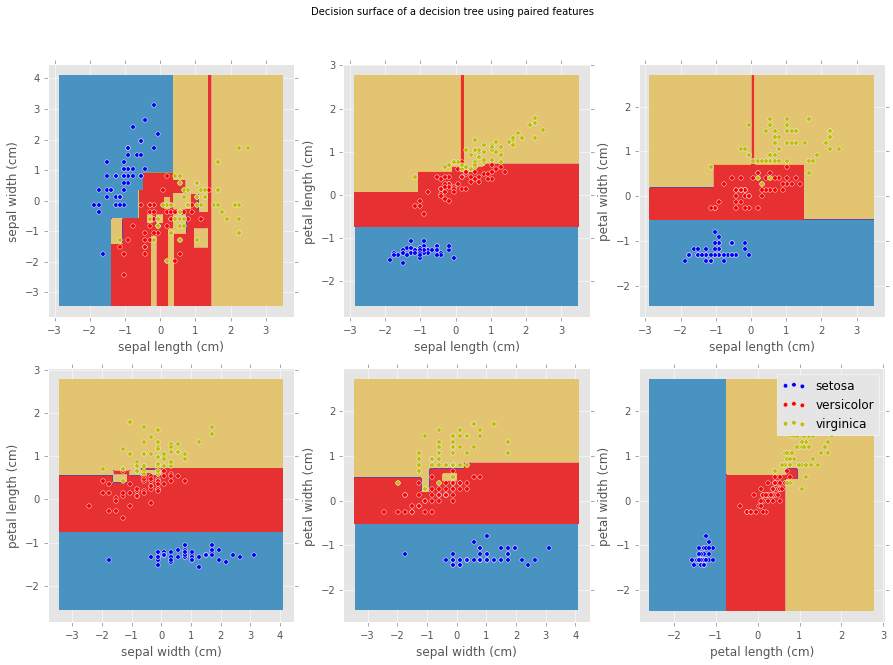

In [18]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

n_classes = 3
plot_colors = "bry"
plot_step = 0.02

# Load data
iris = load_iris()
plt.rcParams["figure.figsize"] = [15,10]

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(13)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # Standardize
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # Train
    clf = tree.DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.Paired)

    plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()
plt.show()

### Регрессия с деревьями решений

В этом случае всё очень похоже, с той разницой, что мы будем пытаться уменьшить среднюю квадратичную ошибку
$$I(S) = \frac{1}{|S|} \sum\limits_{i \in S} (y_i - c)^2 $$ 
$$ c = \frac{1}{|S|}\sum\limits_{i \in S} y_i $$

In [19]:
from sklearn import tree
X = [[0, 0], [2, 2]]
y = [0.5, 2.5]
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, y)
clf.predict([[1, 1]])

array([ 0.5])

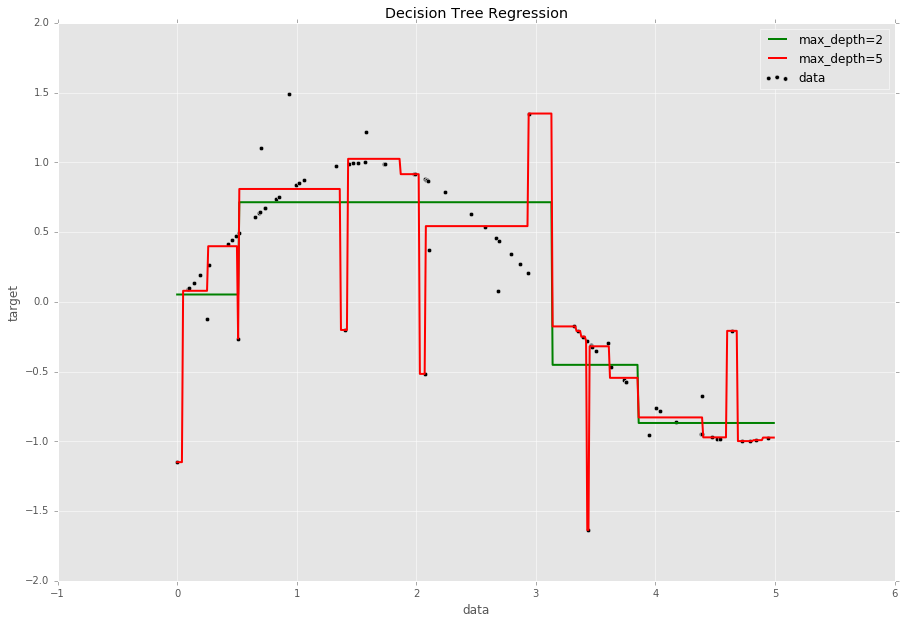

In [20]:
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = tree.DecisionTreeRegressor(max_depth=2)
regr_2 = tree.DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, c="k", label="data")
plt.plot(X_test, y_1, c="g", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, c="r", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### Перейдем к заданию

Загрузите [данные](https://www.dropbox.com/s/3t1moa1wpflx2u9/california.dat?dl=0).

**Задание 1:** Найти оптимальную глубину дерева.<br/>
Разделите выборку на train-test в пропорции 70/30.<br/>
Обучите деревья с глубиной от `1` до `30`. Для каждой глубины расчитайте среднюю квадратичную ошибку на train и на test<br/>
Изобразите эти ошибки на одном графике, сделайте вывод по поводу оптимальной глубины дерева.

In [7]:
import numpy as np
import pandas as pd

df = pd.read_csv('california.dat')
df.columns

Index(['Longitude', 'Latitude', 'HousingMedianAge', 'TotalRooms',
       'TotalBedrooms', 'Population', 'Households', 'MedianIncome',
       'MedianHouseValue'],
      dtype='object')

In [8]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(df, test_size = 0.3)
X_train = train[['Longitude', 'Latitude', 'HousingMedianAge', 'TotalRooms',
           'TotalBedrooms', 'Population', 'Households', 'MedianIncome']]
X_train = X_train.as_matrix()
Y_train = train['MedianHouseValue']
Y_train = Y_train.as_matrix()
X_test = test[['Longitude', 'Latitude', 'HousingMedianAge', 'TotalRooms', 
               'TotalBedrooms', 'Population', 'Households', 'MedianIncome']]
X_test = X_test.as_matrix()

In [19]:
L_sq_test = []
L_sq_train = []
for i in range(1,31):
    sq_train = 0
    sq_test = 0
    regr = tree.DecisionTreeRegressor(max_depth=i)
    regr = regr.fit(X_train,Y_train)
    predicted_test = regr.predict(X_test)
    predicted_train = regr.predict(X_train)
    for j in range(len(X_test)):
        b = (predicted_test[j]-test.MedianHouseValue.values[j])**2
        sq_test += b  
        d = (predicted_train[j]-train.MedianHouseValue.values[j])**2
        sq_train += d 
    L_sq_test.append((sq_test/len(X_test)))
    L_sq_train.append((sq_train/len(X_train)))
print(L_sq_test, L_sq_train, len(L_sq_train), sep = '\n')

[9162984923.6649971, 7273173289.2949286, 6634124655.9108706, 5945933770.3410187, 5382786491.5724792, 4922397143.1966362, 4360572705.9608269, 4132640423.675107, 3927498253.7892542, 4049712466.806438, 4102242722.2951369, 4210170685.9553609, 4371415822.5463409, 4523922250.9071684, 4550878570.7600431, 4486489616.3257933, 4693602444.5234222, 4777758755.8286591, 4710338213.1274462, 4737270399.6550131, 4787874200.8085222, 4819023624.6374531, 4802380237.8006659, 4798245102.0832376, 4826031435.5398502, 4873888366.0922947, 4817854863.7052488, 4765273185.1706514, 4786295480.2496948, 4740031609.896966]
[3892166393.9981799, 3124946500.7357817, 2850645967.969408, 2554517656.1462436, 2278071116.6568866, 2021447354.1418178, 1703182522.2175119, 1411514960.6309538, 1151800520.4454684, 950908588.57283723, 753873196.91362965, 568099865.02089238, 406384833.49240571, 292690020.11719745, 190899507.63467208, 128131211.62118016, 86243352.981626272, 55547607.957375117, 32975754.97716238, 18862397.618007243, 821

Для глубины дерева на тестовой выборке, равной 9, получается минимальная квадратичная ошибка 3927498253.79
Для глубины дерева на обучающей выборке, равной 30, получается минимальная квадратичная ошибка 2265.95929413


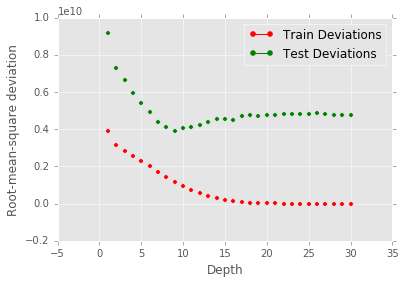

In [21]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.style.use('ggplot')
%matplotlib inline

x_axis = np.arange(1,31)
y_axis_1 = np.asarray(L_sq_test)
y_axis_2 = np.asarray(L_sq_train)

plt.figure()
plt.scatter(x_axis, y_axis_1, c="g", label="data")
plt.scatter(x_axis, y_axis_2, c="r", label="data")
plt.xlabel("Depth")
plt.ylabel("Root-mean-square deviation")

red_line = mlines.Line2D([], [], color='red', marker='.', 
markersize=10, label='Train Deviations') 
green_line = mlines.Line2D([], [], color='green', marker='.', 
markersize=10, label='Test Deviations') 
plt.legend(handles=[red_line, green_line])

print('Для глубины дерева на тестовой выборке, равной ', np.argmin(y_axis_1)+1, ', получается минимальная квадратичная ошибка ', y_axis_1.min(), sep = '')
print('Для глубины дерева на обучающей выборке, равной ', np.argmin(y_axis_2)+1, ', получается минимальная квадратичная ошибка ', y_axis_2.min(), sep = '')

**Задание 2:** Выведите важности признаков. Для этого воспользуйтесь `DecisionTreeRegressor.feature_importances_`

In [22]:
importances = tree.DecisionTreeRegressor().fit(X_train,Y_train).feature_importances_
importances
for i in range(len(df.columns)-1):
    print(df.columns[i], importances[i])

Longitude 0.173518845773
Latitude 0.154204927899
HousingMedianAge 0.0654265859388
TotalRooms 0.0253094435545
TotalBedrooms 0.0275214752874
Population 0.0347410421779
Households 0.0191094352478
MedianIncome 0.500168244121


**Задание 3:** Поразмышляйте на темы:
* Обработки пропусков в данных.
* Как сделать разделяющие плоскости непараллельные осям?

1. Говоря о деревьях решений, стоит отметить, что этот вид подхода к анализу данных весьма эффективен с той точки зрения, что он достаточно хорошо обходит проблему пропуска данных. Однако, весьма важен тот факт, что для обхода пропусков нужно провести некоторую работу, связанную с дополнительными действиями как на стадии обучения, так и на стадии классификации объектов. Кроме того, деревья могут быть использованы для заполнения пропусков наиболее вероятным значением или, например, медианным значением. Использование такого метода будет обладать и достоинствами, и недостатками. Во-первых, данный подход к анализу данных имеет весьма простой и гибкий алгоритм. Во-вторых, данный алгоритм также весьма эффективен и с вычислительной точки зрения. Что касается недостатков, то основным, пожалуй, считается высокая вероятность переобучения. Более того, данный алгоритм обладает высокой чувствительностью к составу выборки.
2. Что касается разделяющих плоскостей, то в деревьях решений сделать их непараллельными осям - нельзя, ведь плоскости делений данного алгоритма всегда параллелны осям маркеров. Именно по этой причине его нельзя использовать для решения всех проблем, возникающих при анализе данных, и именно по этой причине данный метод весьма ограничен в возможности делать точные предсказания.